In [1]:
import os, time, itertools, sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from copy import deepcopy
from pybaseball import *
sys.path.append('/home/dcooper/rockies/RockiesAnalysis/')
from utils.plotting.spray_chart import *

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Get batted ball data

In [2]:
# Load/build database
if not os.path.exists('../data/2020-2025_allBattedBallData.csv'):
    dfs = []
    for year in range(2020, 2026):
        print(f"Pulling {year}...")
        try:
            df = statcast(
                start_dt=f"{year}-03-01",
                end_dt=f"{year}-10-01",
                verbose=False
            )
            # Keep only balls in play
            df = df[df['type'] == 'X']
            dfs.append(df)
            time.sleep(5)  # be nice to Savant
        except Exception as e:
            print(f"Failed for {year}: {e}")
    
    all_bb_data = pd.concat(dfs, ignore_index=True)
    all_bb_data.to_csv('../data/2020-2025_allBattedBallData.csv')
else:
    all_bb_data = pd.read_csv('../data/2020-2025_allBattedBallData.csv', index_col=0)

# Filter to regular season games
all_bb_data = all_bb_data.loc[all_bb_data['game_type'] == 'R']

# Display dataframe
print(all_bb_data.shape)
all_bb_data.head()

(658753, 118)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
773,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,field_out,hit_into_play,...,NaN,1.38,0.86,-0.86,35.1,NaN,NaN,NaN,NaN,NaN
774,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,field_out,hit_into_play,...,NaN,1.25,0.92,-0.92,36.2,NaN,NaN,NaN,NaN,NaN
775,SI,2020-09-27,96.7,-2.20,5.92,"Cederlind, Blake",596019,664977,field_out,hit_into_play,...,2.0,1.92,1.44,-1.44,35.1,NaN,NaN,NaN,NaN,NaN
776,SI,2020-09-27,98.0,-2.19,5.94,"Cederlind, Blake",640458,664977,field_out,hit_into_play,...,3.0,1.82,1.38,1.38,34.1,NaN,NaN,NaN,NaN,NaN
777,FF,2020-09-27,91.3,2.59,5.99,"Hand, Brad",624428,543272,field_out,hit_into_play,...,NaN,1.37,1.09,1.09,27.2,NaN,NaN,NaN,NaN,NaN


In [3]:
# Set bins
ev_labels = np.array(['<80', '80-85', '85-90', '90-95', '95-100', '100-105', '105-110', '>=110'])
ev_bins = np.array([0,80,85,90,95,100,105,110,999])
la_labels = np.array(['<10°', '10-25°', '25-35°', '35-50°', '>=50°'])
la_bins = np.array([-999, 10, 25, 35, 50, 999])
sa_labels = np.array(['-45 to -27°', '-27 to -9°', '-9 to 9°', '9 to 27°', '27 to 45°'])
sa_bins = np.array([-999, -27,  -9,  9,  27, 999])

# Add spray angle column
all_bb_data.insert(0, 'spray_angle', value=np.degrees(np.arctan2(all_bb_data['hc_x'] - 125, 199 - all_bb_data['hc_y'])), allow_duplicates=False)

# Add bin columns 
all_bb_data.insert(0, 'launch_speed_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'launch_angle_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'spray_angle_bin', value='', allow_duplicates=False)

# Reorder columns
tgt_cols = ['launch_speed', 'launch_speed_bin', 'launch_angle', 'launch_angle_bin', 'spray_angle', 'spray_angle_bin', 'events', 'home_team', 'hc_x', 'hc_y', 'stand', 'batter', 'game_year'] 
df = all_bb_data[tgt_cols]

# Add data to new columns
df.loc[:,'launch_speed_bin'] = pd.cut(df['launch_speed'], ev_bins, labels=ev_labels, right=False)
df.loc[:,'launch_angle_bin'] = pd.cut(df['launch_angle'], la_bins, labels=la_labels, right=False)
df.loc[:,'spray_angle_bin'] = pd.cut(df['spray_angle'], sa_bins, labels=sa_labels, right=False)

df.head()

,launch_speed,launch_speed_bin,launch_angle,launch_angle_bin,spray_angle,spray_angle_bin,events,home_team,hc_x,hc_y,stand,batter,game_year
773,88.4,85-90,32.0,25-35°,43.763679,27 to 45°,field_out,CLE,217.94,101.96,R,605137,2020
774,102.0,100-105,41.0,35-50°,-5.926369,-9 to 9°,field_out,CLE,108.85,43.42,R,663647,2020
775,100.5,100-105,-20.0,<10°,24.128726,9 to 27°,field_out,CLE,152.61,137.36,L,596019,2020
776,84.1,80-85,22.0,10-25°,-19.733931,-27 to -9°,field_out,CLE,81.95,78.99,R,640458,2020
777,88.7,85-90,17.0,10-25°,-26.614826,-27 to -9°,field_out,CLE,76.57,102.35,L,624428,2020


## Build expected outcomes

In [4]:
# Build expected outcomes table
exp_outcomes = pd.DataFrame(columns=['EV', 'LA', 'SA', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'Bases_nCoors', 'Bases_Coors', 'n_Coors'])

# Check for valid events
valid_events = [
    'home_run', 'triple', 'double', 'single',
    'field_out', 'sac_fly', 'force_out',
    'double_play', 'grounded_into_double_play',
    'fielders_choice_out', 'fielders_choice',
    'triple_play', 'sac_fly_double_play'
]
df = df.loc[df['events'].isin(valid_events)]

# Iterate through bin type combinations
for ev_bin, la_bin, sa_bin in itertools.product(ev_labels, la_labels, sa_labels):

    # Filter by bin types
    bin_df = df.loc[df['launch_speed_bin'] == ev_bin]
    bin_df = bin_df.loc[bin_df['launch_angle_bin'] == la_bin]
    bin_df = bin_df.loc[bin_df['spray_angle_bin'] == sa_bin]

    # Split by location
    c_bin_df = bin_df.loc[bin_df['home_team'] == 'COL']
    nc_bin_df = bin_df.loc[bin_df['home_team'] != 'COL']

    # Iterate through outcomes and compute deltas for hits
    nc = []
    c = []
    deltas = []
    for event in ['home_run', 'triple', 'double', 'single', 'out']:

        # Get event occurance
        if event == 'out':
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
        else:
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'] == event].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'] == event].shape[0]

        # Convert to proBIPilities
        try:
            nc_p_event = nc_n_event / nc_bin_df.shape[0]
            c_p_event = c_n_event / c_bin_df.shape[0]
        except ZeroDivisionError:
            deltas.append(np.nan)
            nc.append(np.nan)
            c.append(np.nan)
            continue

        # Compute delta proBIPilities
        d_p_event = c_p_event - nc_p_event
        deltas.append(d_p_event)
        nc.append(nc_p_event)
        c.append(c_p_event)

    nc_bases = 4 * nc[0] + 3 * nc[1] + 2 * nc[2] + nc[1]
    c_bases = 4 * c[0] + 3 * c[1] + 2 * c[2] + c[1]
    exp_outcomes.loc[exp_outcomes.shape[0]] = [ev_bin, la_bin, sa_bin]  + deltas + [nc_bases, c_bases] + [c_bin_df.shape[0]]

# Drop NA
exp_outcomes.dropna(inplace=True)

# Drop anywhere n_Coors < 50
exp_outcomes = exp_outcomes.loc[exp_outcomes['n_Coors'] >= 50]

# Add delta bases
d_bases = 4 * exp_outcomes['ΔHR'] + 3 * exp_outcomes['Δ3B'] + 2 * exp_outcomes['Δ2B'] + exp_outcomes['Δ1B']
exp_outcomes.insert(10, 'ΔBases', d_bases)

# Round 
exp_outcomes = exp_outcomes.round(2)

## Get Rockies hitters from 2020-2025

In [5]:
# Load dataframe
team_df = pd.read_csv('../data/RockiesBatters.csv')
team_df.head()

# Filter data frame
keep_inds = []
for i, r in team_df.iterrows():
    if r['To'] < 2020:
        continue
    if r['Pos Summary'][0] == '1':
        continue
    if r['G'] == 0:
        continue
    keep_inds.append(i)

team_df = team_df.loc[keep_inds]
team_df.head()

,Rk,Name,S,C,F,Yrs,From,To,ASG,G,...,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,Pos Summary,Name-additional
5,6,Matt Adams,-,-,F,1,2021,2021,0,22,...,0.0,4.0,9.0,0.167,0.250,0.194,0.444,17.0,-3,adamsma01
11,12,Jorge Alfaro,-,-,-,1,2023,2023,0,10,...,0.0,0.0,12.0,0.161,0.188,0.387,0.575,44.0,-2,alfarjo01
18,19,Adael Amador,S,C,F,2,2024,2025,0,51,...,1.0,12.0,33.0,0.176,0.242,0.250,0.492,32.0,4,amadoad01
27,28,Orlando Arcia,-,-,F,1,2025,2025,0,62,...,1.0,9.0,39.0,0.203,0.242,0.302,0.544,44.0,-4-5-6-3,arciaor01
29,30,Nolan Arenado,S,-,-,8,2013,2020,5,1079,...,15.0,362.0,684.0,0.293,0.349,0.541,0.890,121.0,+5,arenano01


## Get player/season transition dataframes 

In [6]:
def get_player_dfs(last_name=None, first_name=None, player_id=None, year=2025, home_team='COL', not_home_team=None):
    if player_id is None:
        player_id = playerid_lookup(last_name, first_name, ignore_accents=True)['key_mlbam'][0]

    player_df = df.loc[df['batter'] == player_id]
    if year is not None:
        player_df = player_df.loc[player_df['game_year'] == year]
    if home_team is not None:
        player_df = player_df.loc[player_df['home_team'] == home_team]
    if not_home_team is not None:
        player_df = player_df.loc[player_df['home_team'] != not_home_team]
    assert player_df.shape[0] > 0, display(playerid_lookup(last_name, first_name, ignore_accents=True))

    print(f'Found {player_df.shape[0]} batted balls for {first_name} {last_name}')

    player_contact = pd.DataFrame(columns=['EV', 'LA', 'SA', 'count', 'prob'])
    for i, ev_label in enumerate(ev_labels):
        for j, la_label in enumerate(la_labels):
            for k, sa_label in enumerate(sa_labels):
                count = player_df.loc[player_df['launch_speed_bin'] == ev_label].loc[player_df['launch_angle_bin'] == la_label].loc[player_df['spray_angle_bin'] == sa_label].shape[0]
                player_contact.loc[player_contact.shape[0]] = [ev_label, la_label, sa_label, count, count/player_df.shape[0]] 

    player_contact = player_contact.sort_values('prob', ascending=False)
    player_contact = player_contact.reset_index(drop=True).round(4)

    return player_contact, player_df

In [7]:
# Visualize
def visualize_transition(T_contact, title=None):
    fig, axs = plt.subplots(2, 2)
    
    compare_arr = np.zeros((len(ev_labels), len(la_labels)))
    for i, ev_label in enumerate(ev_labels):
        for j, la_label in enumerate(la_labels):
            compare_arr[i,j] = T_contact.loc[T_contact['EV'] == ev_label].loc[T_contact['LA'] == la_label]['%'].mean()
    
    axs[1,0].imshow(compare_arr.T, cmap='bwr', vmin=-5, vmax=5)
    axs[1,0].set_yticks(np.arange(len(la_labels)), la_labels)
    axs[1,0].set_ylabel('LA')
    axs[1,0].set_xlabel('EV')
    axs[1,0].set_xticks(np.arange(len(ev_labels)), ev_labels, rotation=90)
    axs[1,0].label_outer()
    
    compare_arr = np.zeros((len(ev_labels), len(sa_labels)))
    for i, ev_label in enumerate(ev_labels):
        for j, sa_label in enumerate(sa_labels):
            compare_arr[i,j] = T_contact.loc[T_contact['EV'] == ev_label].loc[T_contact['SA'] == sa_label]['%'].mean()
    
    axs[0,0].imshow(compare_arr.T, cmap='bwr', vmin=-5, vmax=5)
    axs[0,0].set_yticks(np.arange(len(sa_labels)), sa_labels)
    axs[0,0].set_ylabel('SA')
    axs[0,0].set_xlabel('EV')
    axs[0,0].set_xticks(np.arange(len(ev_labels)), ev_labels, rotation=90)
    axs[0,0].label_outer()
    
    compare_arr = np.zeros((len(la_labels), len(sa_labels)))
    for i, la_label in enumerate(la_labels):
        for j, sa_label in enumerate(sa_labels):
            compare_arr[i,j] = T_contact.loc[T_contact['LA'] == la_label].loc[T_contact['SA'] == sa_label]['%'].mean()
    
    axs[1,1].imshow(compare_arr.T, cmap='bwr', vmin=-5, vmax=5)
    axs[1,1].set_xticks(np.arange(len(sa_labels)), sa_labels, rotation=90)
    axs[1,1].set_xlabel('SA')
    axs[1,1].set_yticks(np.arange(len(la_label)), la_labels)
    axs[1,1].label_outer()
    
    axs[0,1].axis('off')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [21]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance_nd

# Iterate through players
T_contact_dfs = []
T_contact_labels = []
d_EV = []
d_LA = []
nc_counts = np.zeros((len(ev_labels), len(la_labels), len(sa_labels)))
c_counts = np.zeros((len(ev_labels), len(la_labels), len(sa_labels)))
for player, yr_from, yr_to in zip(team_df['Name'].to_list(), team_df['From'], team_df['To']):
    first, last = player.split()[0], ' '.join(player.split()[1:])
    
    # Iterate through seasons
    for season in range(2020,2026):

        # Check year
        if season < yr_from or season > yr_to:
            continue
            
        # Get player contact types
        print(last, first, season)
        try:
            c_contact, c_bb = get_player_dfs(last, first, year=season, home_team='COL', not_home_team=None)
            nc_contact, nc_bb = get_player_dfs(last, first, year=season, home_team=None, not_home_team='COL')            
        except:
            print(f'>>>Failed for {last} {first} {season}')
            continue

        # Check sample sizes
        if c_contact['count'].sum() < 50 or nc_contact['count'].sum() < 50:
            continue

        # Get delta EV
        c_EV, nc_EV = c_bb['launch_speed'], nc_bb['launch_speed']
        d_EV.append(c_EV.mean() - nc_EV.mean())
        
        # Get delta LA
        c_LA, nc_LA = c_bb['launch_angle'], nc_bb['launch_angle']
        d_LA.append(c_LA.mean() - nc_LA.mean())
        
        # Make transition dataframe
        T_contact = pd.DataFrame(columns=['EV', 'LA', 'SA', 'count', '%'])
        for i, ev_label in enumerate(ev_labels):
            for j, la_label in enumerate(la_labels):
                for k, sa_label in enumerate(sa_labels):
                    nc_count = nc_contact.loc[nc_contact['EV'] == ev_label].loc[nc_contact['LA'] == la_label].loc[nc_contact['SA'] == sa_label]['count'].to_numpy()[0]
                    c_count = c_contact.loc[c_contact['EV'] == ev_label].loc[c_contact['LA'] == la_label].loc[c_contact['SA'] == sa_label]['count'].to_numpy()[0]
                    nc_prob = nc_contact.loc[nc_contact['EV'] == ev_label].loc[nc_contact['LA'] == la_label].loc[nc_contact['SA'] == sa_label]['prob'].to_numpy()[0]
                    c_prob = c_contact.loc[c_contact['EV'] == ev_label].loc[c_contact['LA'] == la_label].loc[c_contact['SA'] == sa_label]['prob'].to_numpy()[0]
                    T_contact.loc[T_contact.shape[0]] = [ev_label, la_label, sa_label, c_count - nc_count, 100 * (c_prob - nc_prob)]
                    nc_counts[i,j,k] += nc_count
                    c_counts[i,j,k] += c_count

        # Add to list
        T_contact_dfs.append(T_contact)
        T_contact_labels.append(f'{last} {first} {season}')

        

Adams Matt 2021
Found 13 batted balls for Matt Adams
Found 13 batted balls for Matt Adams
Alfaro Jorge 2023
Found 6 batted balls for Jorge Alfaro
Found 27 batted balls for Jorge Alfaro
Amador Adael 2024
Found 19 batted balls for Adael Amador
Found 9 batted balls for Adael Amador
Amador Adael 2025
Found 48 batted balls for Adael Amador
Found 37 batted balls for Adael Amador
Arcia Orlando 2025
Found 66 batted balls for Orlando Arcia
Found 88 batted balls for Orlando Arcia
Arenado Nolan 2020
Found 95 batted balls for Nolan Arenado
Found 70 batted balls for Nolan Arenado
Beck Jordan 2024
Found 51 batted balls for Jordan Beck
Found 53 batted balls for Jordan Beck
Beck Jordan 2025
Found 209 batted balls for Jordan Beck
Found 152 batted balls for Jordan Beck
Bernabel Warming 2025
Found 52 batted balls for Warming Bernabel
Found 60 batted balls for Warming Bernabel
Bernard Wynton 2022
Found 22 batted balls for Wynton Bernard
Found 11 batted balls for Wynton Bernard
Blackmon Charlie 2020
Found 

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,castellani,ryan,624418,castr005,castery01,16377,2020.0,2022.0


>>>Failed for Castellani Ryan 2020
Castellani Ryan 2021
Found 1 batted balls for Ryan Castellani


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,castellani,ryan,624418,castr005,castery01,16377,2020.0,2022.0


>>>Failed for Castellani Ryan 2021
Castro Harold 2023
Found 95 batted balls for Harold Castro
Found 97 batted balls for Harold Castro
Cave Jake 2024
Found 123 batted balls for Jake Cave
Found 104 batted balls for Jake Cave
Crim Blaine 2025
Found 16 batted balls for Blaine Crim
Found 23 batted balls for Blaine Crim
Criswell Jeff 2024


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,criswell,jeff,676105,crisj001,criswje01,-1,2024.0,2024.0


>>>Failed for Criswell Jeff 2024
Cron C.J. 2021
>>>Failed for Cron C.J. 2021
Cron C.J. 2022
>>>Failed for Cron C.J. 2022
Cron C.J. 2023
>>>Failed for Cron C.J. 2023
Dahl David 2020
Found 41 batted balls for David Dahl
Found 24 batted balls for David Dahl
Daza Yonathan 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,daza,yonathan,602074,dazay001,dazayo01,15794,2019.0,2023.0


>>>Failed for Daza Yonathan 2020
Daza Yonathan 2021
Found 135 batted balls for Yonathan Daza
Found 102 batted balls for Yonathan Daza
Daza Yonathan 2022
Found 147 batted balls for Yonathan Daza
Found 160 batted balls for Yonathan Daza
Daza Yonathan 2023
Found 29 batted balls for Yonathan Daza
Found 33 batted balls for Yonathan Daza
Díaz Elias 2020
Found 18 batted balls for Elias Díaz
Found 34 batted balls for Elias Díaz
Díaz Elias 2021
Found 141 batted balls for Elias Díaz
Found 138 batted balls for Elias Díaz
Díaz Elias 2022
Found 138 batted balls for Elias Díaz
Found 124 batted balls for Elias Díaz
Díaz Elias 2023
Found 185 batted balls for Elias Díaz
Found 182 batted balls for Elias Díaz
Díaz Elias 2024
Found 126 batted balls for Elias Díaz
Found 129 batted balls for Elias Díaz
Diehl Phillip 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,diehl,phillip,670426,diehp001,diehlph01,20030,2019.0,2022.0


>>>Failed for Diehl Phillip 2020
Doyle Brenton 2023
Found 120 batted balls for Brenton Doyle
Found 127 batted balls for Brenton Doyle
Doyle Brenton 2024
Found 202 batted balls for Brenton Doyle
Found 192 batted balls for Brenton Doyle
Doyle Brenton 2025
Found 191 batted balls for Brenton Doyle
Found 172 batted balls for Brenton Doyle
Estévez Carlos 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,estevez,carlos,608032,estec001,estevca01,14542,2016.0,2025.0


>>>Failed for Estévez Carlos 2020
Estévez Carlos 2021


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,estevez,carlos,608032,estec001,estevca01,14542,2016.0,2025.0


>>>Failed for Estévez Carlos 2021
Estévez Carlos 2022


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,estevez,carlos,608032,estec001,estevca01,14542,2016.0,2025.0


>>>Failed for Estévez Carlos 2022
Estrada Thairo 2025
Found 71 batted balls for Thairo Estrada
Found 58 batted balls for Thairo Estrada
Farmer Kyle 2025
Found 97 batted balls for Kyle Farmer
Found 114 batted balls for Kyle Farmer
Fernández Julian 2021


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,fernandez,julian,642759,fernj007,fernaju02,18341,2021.0,2025.0


>>>Failed for Fernández Julian 2021
Fernández Yanquiel 2025
Found 53 batted balls for Yanquiel Fernández
Found 42 batted balls for Yanquiel Fernández
Freeman Tyler 2025
Found 185 batted balls for Tyler Freeman
Found 143 batted balls for Tyler Freeman
Fuentes Joshua 2020
Found 37 batted balls for Joshua Fuentes
Found 33 batted balls for Joshua Fuentes
Fuentes Joshua 2021
Found 110 batted balls for Joshua Fuentes
Found 94 batted balls for Joshua Fuentes
Fulford Braxton 2025
Found 37 batted balls for Braxton Fulford
Found 38 batted balls for Braxton Fulford
Goodman Hunter 2023
Found 23 batted balls for Hunter Goodman
Found 25 batted balls for Hunter Goodman
Goodman Hunter 2024
Found 80 batted balls for Hunter Goodman
Found 69 batted balls for Hunter Goodman
Goodman Hunter 2025
Found 204 batted balls for Hunter Goodman
Found 180 batted balls for Hunter Goodman
Goudeau Ashton 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,goudeau,ashton,623485,gouda001,goudeas01,15139,2020.0,2022.0


>>>Failed for Goudeau Ashton 2020
Goudeau Ashton 2021
Found 1 batted balls for Ashton Goudeau
Found 1 batted balls for Ashton Goudeau
Goudeau Ashton 2022


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,goudeau,ashton,623485,gouda001,goudeas01,15139,2020.0,2022.0


>>>Failed for Goudeau Ashton 2022
Grichuk Randal 2022
Found 214 batted balls for Randal Grichuk
Found 155 batted balls for Randal Grichuk
Grichuk Randal 2023
Found 88 batted balls for Randal Grichuk
Found 249 batted balls for Randal Grichuk
Hampson Garrett 2020
Found 49 batted balls for Garrett Hampson
Found 59 batted balls for Garrett Hampson
Hampson Garrett 2021
Found 180 batted balls for Garrett Hampson
Found 149 batted balls for Garrett Hampson
Hampson Garrett 2022
Found 63 batted balls for Garrett Hampson
Found 72 batted balls for Garrett Hampson
Harvey Joe 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,harvey,joe,642840,harvj001,harvejo01,16459,2019.0,2020.0


>>>Failed for Harvey Joe 2020
Hilliard Sam 2020
Found 28 batted balls for Sam Hilliard
Found 35 batted balls for Sam Hilliard
Hilliard Sam 2021
Found 68 batted balls for Sam Hilliard
Found 55 batted balls for Sam Hilliard
Hilliard Sam 2022
Found 72 batted balls for Sam Hilliard
Found 44 batted balls for Sam Hilliard
Hilliard Sam 2023


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,hilliard,sam,656541,hills005,hillisa01,17954,2019.0,2025.0


>>>Failed for Hilliard Sam 2023
Hilliard Sam 2024
Found 48 batted balls for Sam Hilliard
Found 35 batted balls for Sam Hilliard
Hilliard Sam 2025
Found 13 batted balls for Sam Hilliard
Found 15 batted balls for Sam Hilliard
Hiura Keston 2025
Found 3 batted balls for Keston Hiura
Found 8 batted balls for Keston Hiura
Iglesias Jose 2022
Found 182 batted balls for Jose Iglesias
Found 196 batted balls for Jose Iglesias
Joe Connor 2021
Found 56 batted balls for Connor Joe
Found 83 batted balls for Connor Joe
Joe Connor 2022
Found 153 batted balls for Connor Joe
Found 152 batted balls for Connor Joe
Jones Greg 2024
Found 1 batted balls for Greg Jones


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,jones,greg,675659,joneg003,jonesgr02,-1,2024.0,2025.0
1,jones,greg,429983,joneg001,jonesgr01,1782,2003.0,2007.0


>>>Failed for Jones Greg 2024
Jones Nolan 2023
Found 132 batted balls for Nolan Jones
Found 108 batted balls for Nolan Jones
Jones Nolan 2024
Found 95 batted balls for Nolan Jones
Found 71 batted balls for Nolan Jones
Kaiser Connor 2023


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kaiser,connor,663731,kaisc001,kaiseco01,21535,2023.0,2025.0


>>>Failed for Kaiser Connor 2023
Karros Kyle 2025
Found 39 batted balls for Kyle Karros
Found 58 batted balls for Kyle Karros
Kauffmann Karl 2023


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kauffmann,karl,666154,kaufk001,kauffka01,27488,2023.0,2023.0


>>>Failed for Kauffmann Karl 2023
Kemp Matt 2020
Found 50 batted balls for Matt Kemp
Found 26 batted balls for Matt Kemp
Martini Nick 2025
Found 38 batted balls for Nick Martini
Found 45 batted balls for Nick Martini
McMahon Ryan 2020
Found 53 batted balls for Ryan McMahon
Found 52 batted balls for Ryan McMahon
McMahon Ryan 2021
Found 200 batted balls for Ryan McMahon
Found 179 batted balls for Ryan McMahon
McMahon Ryan 2022
Found 211 batted balls for Ryan McMahon
Found 152 batted balls for Ryan McMahon
McMahon Ryan 2023
Found 172 batted balls for Ryan McMahon
Found 185 batted balls for Ryan McMahon
McMahon Ryan 2024
Found 188 batted balls for Ryan McMahon
Found 198 batted balls for Ryan McMahon
McMahon Ryan 2025
Found 114 batted balls for Ryan McMahon
Found 209 batted balls for Ryan McMahon
Miller Owen 2025
Found 8 batted balls for Owen Miller
Found 2 batted balls for Owen Miller
Moniak Mickey 2025
Found 180 batted balls for Mickey Moniak
Found 147 batted balls for Mickey Moniak
Monte

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,nunez,dom,624513,nuned001,nunezdo01,15055,2019.0,2025.0


>>>Failed for Nuñez Dom 2020
Nuñez Dom 2021
Found 76 batted balls for Dom Nuñez
Found 59 batted balls for Dom Nuñez
Nuñez Dom 2022
Found 14 batted balls for Dom Nuñez
Found 11 batted balls for Dom Nuñez
Owings Chris 2020
Found 22 batted balls for Chris Owings
Found 8 batted balls for Chris Owings
Owings Chris 2021
Found 19 batted balls for Chris Owings
Found 8 batted balls for Chris Owings
Pazos James 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,pazos,james,572021,pazoj001,pazosja01,13323,2015.0,2020.0


>>>Failed for Pazos James 2020
Pillar Kevin 2020
Found 35 batted balls for Kevin Pillar
Found 130 batted balls for Kevin Pillar
Profar Jurickson 2023
Found 171 batted balls for Jurickson Profar
Found 202 batted balls for Jurickson Profar
Ritter Ryan 2025
Found 82 batted balls for Ryan Ritter
Found 43 batted balls for Ryan Ritter
Rodgers Brendan 2020
Found 6 batted balls for Brendan Rodgers
Found 9 batted balls for Brendan Rodgers
Rodgers Brendan 2021
Found 156 batted balls for Brendan Rodgers
Found 143 batted balls for Brendan Rodgers
Rodgers Brendan 2022
Found 207 batted balls for Brendan Rodgers
Found 210 batted balls for Brendan Rodgers
Rodgers Brendan 2023
Found 72 batted balls for Brendan Rodgers
Found 64 batted balls for Brendan Rodgers
Rodgers Brendan 2024
Found 184 batted balls for Brendan Rodgers
Found 184 batted balls for Brendan Rodgers
Romo Drew 2024
Found 20 batted balls for Drew Romo
Found 13 batted balls for Drew Romo
Romo Drew 2025


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,romo,drew,691011,romod001,romodr01,-1,2024.0,2025.0


>>>Failed for Romo Drew 2025
Rosscup Zac 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,rosscup,zac,573127,rossz001,rosscza01,9419,2013.0,2021.0


>>>Failed for Rosscup Zac 2020
Rosscup Zac 2021


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,rosscup,zac,573127,rossz001,rosscza01,9419,2013.0,2021.0


>>>Failed for Rosscup Zac 2021
Ruiz Rio 2021
Found 10 batted balls for Rio Ruiz
Found 79 batted balls for Rio Ruiz
Santos Antonio 2020


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,santos,antonio,665733,santa004,santoan02,20383,2020.0,2021.0


>>>Failed for Santos Antonio 2020
Santos Antonio 2021


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,santos,antonio,665733,santa004,santoan02,20383,2020.0,2021.0


>>>Failed for Santos Antonio 2021
Schunk Aaron 2024
Found 48 batted balls for Aaron Schunk
Found 14 batted balls for Aaron Schunk
Schunk Aaron 2025
Found 14 batted balls for Aaron Schunk
Found 8 batted balls for Aaron Schunk
Serven Brian 2022
Found 82 batted balls for Brian Serven
Found 57 batted balls for Brian Serven
Serven Brian 2023
Found 7 batted balls for Brian Serven
Found 6 batted balls for Brian Serven
Stallings Jacob 2024
Found 85 batted balls for Jacob Stallings
Found 93 batted balls for Jacob Stallings
Stallings Jacob 2025
Found 25 batted balls for Jacob Stallings
Found 53 batted balls for Jacob Stallings
Story Trevor 2020
Found 90 batted balls for Trevor Story
Found 80 batted balls for Trevor Story
Story Trevor 2021
Found 212 batted balls for Trevor Story
Found 171 batted balls for Trevor Story
Tapia Raimel 2020
Found 69 batted balls for Raimel Tapia
Found 78 batted balls for Raimel Tapia
Tapia Raimel 2021
Found 228 batted balls for Raimel Tapia
Found 179 batted balls for 

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,tinoco,jesus,622786,tinoj001,tinocje01,16300,2019.0,2025.0


>>>Failed for Tinoco Jesús 2020
Tinoco Jesús 2021


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,tinoco,jesus,622786,tinoj001,tinocje01,16300,2019.0,2025.0


>>>Failed for Tinoco Jesús 2021
Toglia Michael 2022
Found 33 batted balls for Michael Toglia
Found 26 batted balls for Michael Toglia
Toglia Michael 2023
Found 46 batted balls for Michael Toglia
Found 44 batted balls for Michael Toglia
Toglia Michael 2024
Found 121 batted balls for Michael Toglia
Found 133 batted balls for Michael Toglia
Toglia Michael 2025
Found 91 batted balls for Michael Toglia
Found 84 batted balls for Michael Toglia
Tovar Ezequiel 2022
Found 7 batted balls for Ezequiel Tovar
Found 10 batted balls for Ezequiel Tovar
Tovar Ezequiel 2023
Found 214 batted balls for Ezequiel Tovar
Found 199 batted balls for Ezequiel Tovar
Tovar Ezequiel 2024
Found 220 batted balls for Ezequiel Tovar
Found 238 batted balls for Ezequiel Tovar
Tovar Ezequiel 2025
Found 130 batted balls for Ezequiel Tovar
Found 132 batted balls for Ezequiel Tovar
Trejo Alan 2021
Found 21 batted balls for Alan Trejo
Found 10 batted balls for Alan Trejo
Trejo Alan 2022
Found 52 batted balls for Alan Trejo
Fo

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,tucker,cole,657061,tuckc001,tuckeco01,17326,2019.0,2024.0


>>>Failed for Tucker Cole 2023
Veen Zac 2025
Found 13 batted balls for Zac Veen
Found 7 batted balls for Zac Veen
Vilade Ryan 2021
Found 1 batted balls for Ryan Vilade
Found 4 batted balls for Ryan Vilade
Welker Colton 2021
Found 9 batted balls for Colton Welker
Found 13 batted balls for Colton Welker
Wolters Tony 2020
Found 37 batted balls for Tony Wolters
Found 31 batted balls for Tony Wolters
Wynns Austin 2023
Found 42 batted balls for Austin Wynns
Found 49 batted balls for Austin Wynns


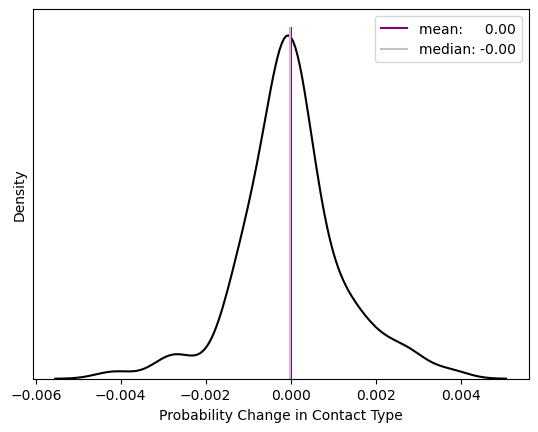

In [65]:
# Plot distribution of corporate bin to bin proBIPility (%) changes  
c_probs = c_counts / c_counts.sum()
nc_probs = nc_counts / nc_counts.sum()
T_probs = (c_probs - nc_probs)
sns.kdeplot(T_probs.flatten(), color='k')
plt.vlines(T_probs.mean(), 0, 450, color='purple', label=f'mean:     {T_probs.mean():.2f}')
plt.vlines(np.median(T_probs), 0, 450, color='silver', label=f'median: {np.median(T_probs):.2f}')
plt.yticks([], [])
plt.legend()
plt.xlabel('ProBIPility Change in Contact Type')
plt.show()

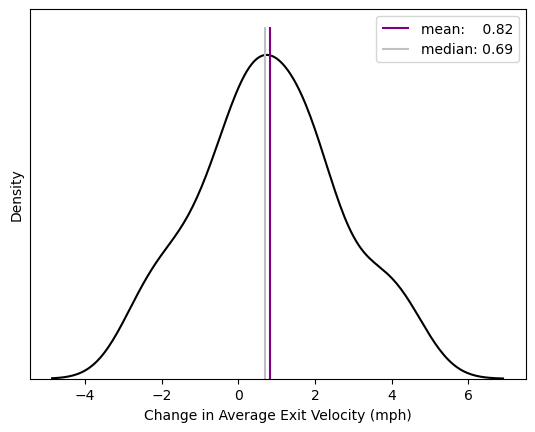

In [68]:
sns.kdeplot(d_EV, color='k')
plt.vlines(np.array(d_EV).mean(), 0, 0.23, color='purple', label=f'mean:    {np.array(d_EV).mean():.2f}')
plt.vlines(np.median(np.array(d_EV)), 0, 0.23, color='silver', label=f'median: {np.median(np.array(d_EV)):.2f}')
plt.yticks([],[])
plt.legend()
plt.xlabel('Change in Average Exit Velocity (mph)')
plt.show()

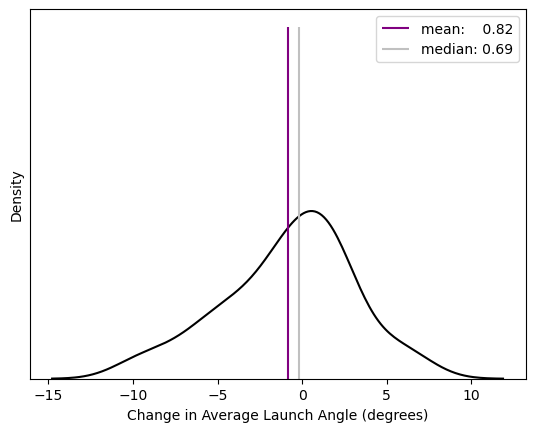

In [70]:
sns.kdeplot(d_LA, color='k')
plt.vlines(np.array(d_LA).mean(), 0, 0.23, color='purple', label=f'mean:    {np.array(d_EV).mean():.2f}')
plt.vlines(np.median(np.array(d_LA)), 0, 0.23, color='silver', label=f'median: {np.median(np.array(d_EV)):.2f}')
plt.yticks([],[])
plt.legend()
plt.xlabel('Change in Average Launch Angle (degrees)')
plt.show()

## Look at change in BIP%

In [75]:
# Load data from Baseball Reference
splits_df = pd.read_excel('../data/2015-2020_HomeRoadBattingSplits.xlsx')
splits_df.head()

,YEAR,Split,G,GS,PA,AB,R,H,2B,3B,...,TB,GDP,HBP,SH,SF,IBB,ROE,BAbip,tOPS+,sOPS+
0,2025,Home,835,81,3022,2747,369,741,160,25,...,1209,63,21,10,26,4,19,0.330,125,109
1,2025,Away,826,81,2886,2661,228,541,93,12,...,880,55,27,11,9,1,15,0.264,74,66
2,2024,Home,810,81,3049,2735,396,729,148,16,...,1194,67,21,11,24,14,23,0.332,118,113
3,2024,Away,823,81,2977,2719,286,590,129,9,...,989,59,30,8,21,6,10,0.282,82,81
4,2023,Home,845,81,3054,2764,425,744,177,20,...,1240,57,29,6,22,4,30,0.331,117,108


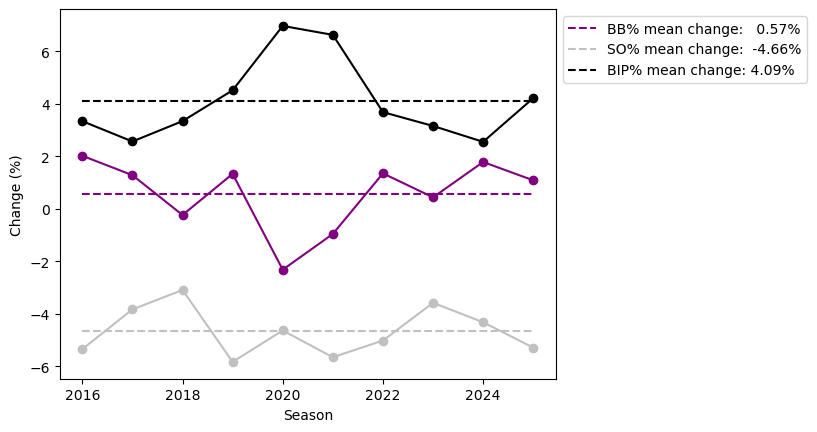

In [121]:
# Get walk splits
years = splits_df['YEAR'].to_list()[::2]
c_BB_rate = 100 * splits_df.loc[splits_df['Split'] == 'Home']['BB'] / splits_df.loc[splits_df['Split'] == 'Home']['PA'] 
nc_BB_rate = 100 * splits_df.loc[splits_df['Split'] == 'Away']['BB'] / splits_df.loc[splits_df['Split'] == 'Away']['PA'] 
c_SO_rate = 100 * splits_df.loc[splits_df['Split'] == 'Home']['SO'] / splits_df.loc[splits_df['Split'] == 'Home']['PA'] 
nc_SO_rate = 100 * splits_df.loc[splits_df['Split'] == 'Away']['SO'] / splits_df.loc[splits_df['Split'] == 'Away']['PA'] 
c_BIP_rate = 100 * ((splits_df.loc[splits_df['Split'] == 'Home']['PA'] - (splits_df.loc[splits_df['Split'] == 'Home']['SO'] + splits_df.loc[splits_df['Split'] == 'Home']['BB'])) / splits_df.loc[splits_df['Split'] == 'Home']['PA'])
nc_BIP_rate = 100 * ((splits_df.loc[splits_df['Split'] == 'Away']['PA'] - (splits_df.loc[splits_df['Split'] == 'Away']['SO'] + splits_df.loc[splits_df['Split'] == 'Away']['BB'])) / splits_df.loc[splits_df['Split'] == 'Away']['PA'])

plt.plot(years, c_BB_rate.to_numpy() - nc_BB_rate.to_numpy(), color='purple', marker='o')
plt.hlines((c_BB_rate.to_numpy() - nc_BB_rate.to_numpy()).mean(), 2016, 2025, color='purple', linestyle='dashed', label=f'BB% mean change:   {(c_BB_rate.to_numpy() - nc_BB_rate.to_numpy()).mean():.2f}%')
plt.plot(years, c_SO_rate.to_numpy() - nc_SO_rate.to_numpy(), color='silver', marker='o')
plt.hlines((c_SO_rate.to_numpy() - nc_SO_rate.to_numpy()).mean(), 2016, 2025, color='silver', linestyle='dashed', label=f'SO% mean change:  {(c_SO_rate.to_numpy() - nc_SO_rate.to_numpy()).mean():.2f}%')
plt.plot(years, c_BIP_rate.to_numpy() - nc_BIP_rate.to_numpy(), color='black', marker='o')
plt.hlines((c_BIP_rate.to_numpy() - nc_BIP_rate.to_numpy()).mean(), 2016, 2025, color='black', linestyle='dashed', label=f'BIP% mean change: {(c_BIP_rate.to_numpy() - nc_BIP_rate.to_numpy()).mean():.2f}%')

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Change (%)')
plt.xlabel('Season')
plt.show()

In [125]:
splits_df.loc[splits_df['Split'] == 'Home']['sOPS+'].to_numpy() - splits_df.loc[splits_df['Split'] == 'Away']['sOPS+'].to_numpy()

array([43, 32, 28, 44, 38, 12, 49, 44, 31, 41])

In [128]:
splits_df.loc[splits_df['Split'] == 'Home']['BAbip'].to_numpy().mean()

np.float64(0.3354)

In [129]:
splits_df.loc[splits_df['Split'] == 'Home']['PA'].to_numpy().mean() * 0.04

np.float64(115.65200000000002)

In [130]:
splits_df.loc[splits_df['Split'] == 'Home']['PA'].to_numpy().mean() * 0.04 * splits_df.loc[splits_df['Split'] == 'Home']['BAbip'].to_numpy().mean()

np.float64(38.7896808)